# Homework 5

Copyright 2018 Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [5]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Beta, MakeGammaPmf, MakeJoint, Joint
import thinkbayes2

import matplotlib.pyplot as plt
import thinkplot
import pandas as pd
import numpy as np
from scipy.stats import norm, hypergeom
import math
from thinkbayes2 import MakePoissonPmf, Cdf, Pmf, MakeGammaPmf,  MakeWeibullPmf
from scipy.special import expit, logit
from itertools import product
import pymc3 as pm


import theano.tensor as tt

/home/cgirard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Climate Change

Use a regression model and data of yearly global temperature anomolies and CO2 ppm levels to see the how a change in CO2 level will alter the global temperature.

In [98]:
loc = "/home/cgirard/ThinkBayes2/examples/"
document = loc + "climate.csv"
df = pd.read_csv(document)
df.head()

,Year,Anomoly,CO2
0,1959,0.0596,315.97
1,1960,0.0204,316.91
2,1961,0.0775,317.64
3,1962,0.0888,318.45
4,1963,0.1068,318.99


### PyMC

In [10]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -.1, .1)
    inter = pm.Uniform('inter', -4, -1)
    sigma = pm.Uniform('sigma', 0, .2)

    y_est = slope* df.CO2 + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed= df.Anomoly)
    trace = pm.sample(4000, tune=2000)

Sampling 4 chains: 100%|██████████| 24000/24000 [00:28<00:00, 844.66draws/s]
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


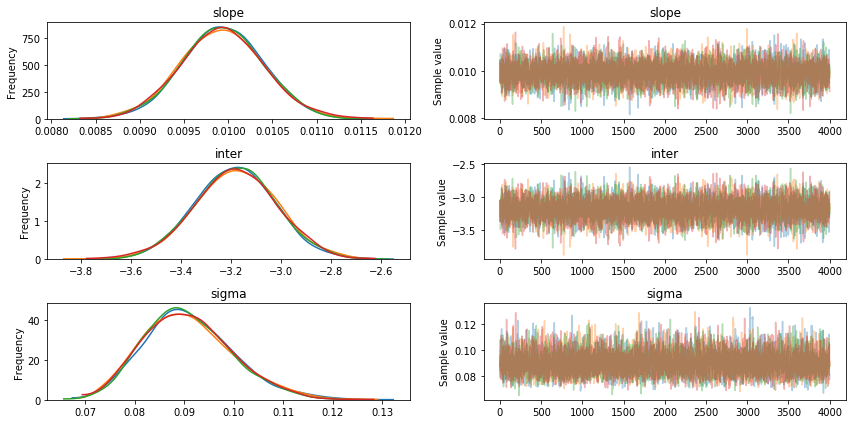

In [11]:
pm.traceplot(trace);

The CO2 has a slope corresponding to temperature anolomy that every change in 1 ppm of CO2 will raise the temperature anomoly by about 0.01. This temperature is starting at about -3.2 anomoly, meaning that up until 320 ppm of CO2 the anomoly will be negative and then it will become positive from there. One thing that is significant is the sigma in this situation, at about 0.09 the deviation for each given point is siginficantly high - meaning that the change to the temperature anomoly can be fairly far from the value given by the slope given the small values of anomolies. 

## Flee Beetle

In [6]:
import pandas as pd

df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


Suppose you discover a new specimen under conditions where it is equally likely to be any of the three species. You measure the aedeagus and width 140 microns and angle 15 (in multiples of 7.5 degrees). What is the probability that it belongs to each species?

In [29]:
from scipy.stats import norm

class Regress(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: x, y
        hypo: slope, inter, sigma
        """
        x,y = data
        width, angle, species = hypo
        
        if x == width and y == angle:
        
            values = df.loc[df['Species']==species]
        
            dist_width = norm(values.Width.mean(), values.Width.std())
            dist_angle = norm(values.Angle.mean(), values.Angle.std())
        
            like_w = dist_width.pdf(width)
            like_a = dist_angle.pdf(angle)
        
            like = like_w * like_a
        
        else:
            like = 0
            
        return like

In [33]:
width = np.linspace(100,200,101)
angle = np.linspace(0,40,41)
species = ('Con', 'Hei', 'Hep')

from itertools import product
hypos = product(width, angle, species)

series = Regress(hypos)

In [34]:
series.Update((140,15))

8.413050395244571e-07

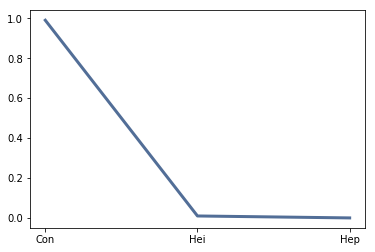

In [35]:
thinkplot.Pdf(series.Marginal(2))

In [42]:
from scipy.stats import norm

grouped = df.groupby('Species')

dist_width = {}
dist_angle = {}
for name, group in grouped:
    dist_width[name] = norm(group.Width.mean(), group.Width.std())
    dist_angle[name] = norm(group.Angle.mean(), group.Angle.std())


In [65]:
model = pm.Model()
observed = (140,15)

with model:
    con = (dist_width['Con'].pdf(observed[0])* dist_angle['Con'].pdf(observed[1]))
    hei = dist_width['Hei'].pdf(observed[0]) * dist_angle['Hei'].pdf(observed[1])
    hep = dist_width['Hep'].pdf(observed[0]) * dist_angle['Hep'].pdf(observed[1])
    normalize = con + hei + hep
    con = con/normalize
    hei = hei/normalize
    hep = hep/normalize
    
    
print('Con = ' + str(con), 'Hei = ' + str(hei), 'Hep = ' + str(hep))

Con = 0.9902199258865487 Hei = 0.009770186966082915 Hep = 9.887147368342703e-06


Quite honeslty, I believe that I did not use PyMC or grid algorithim to the full capability to this problem althought I am a bit confused as to how to change it more to better utilize both methods.

## Dexterity

In [13]:
loc = "/home/cgirard/ThinkBayes2/examples/"
document = loc + "dexterity .csv"
dx = pd.read_csv(document)
dx.head()

,Time,Speed,Age,Dominant,Gender,HD,Used
0,18.12,3.311258,11.906913,0,1,R,L
1,21.21,2.828854,16.366872,0,1,R,L
2,38.12,1.573977,5.037645,0,1,R,L
3,21.34,2.811621,11.356605,1,0,R,R
4,26.31,2.280502,7.556468,1,1,R,R


Relationship of age to speed

In [6]:
with pm.Model() as model:
    slope = pm.Uniform('slope', -5, 5)
    inter = pm.Uniform('inter', -5, 5)
    sigma = pm.Uniform('sigma', 0, 5)

    y_est = slope* dx.Age + inter
    y = pm.Normal('y', mu=y_est, sd=sigma, observed= dx.Speed)
    trace = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, inter, slope]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:11<00:00, 2060.14draws/s]
The acceptance probability does not match the target. It is 0.6913942330699087, but should be close to 0.8. Try to increase the number of tuning steps.


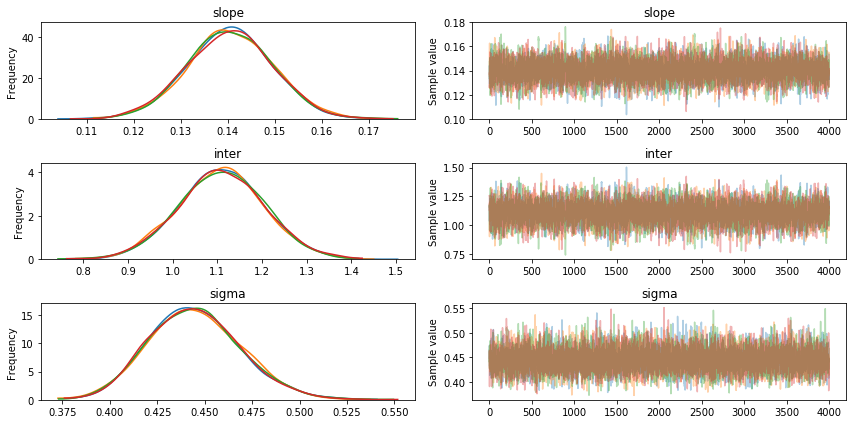

In [8]:
pm.traceplot(trace);

#### Obeserving Differences in the Groups

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [speed]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5937.40draws/s]
The acceptance probability does not match the target. It is 0.8858829107631935, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [speed]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5499.22draws/s]
The acceptance probability does not match the target. It is 0.8862723127974129, but should be close to 0.8. Try to increase the number of tuning steps.


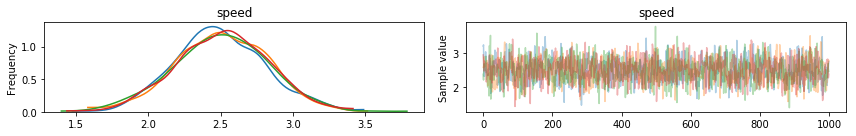

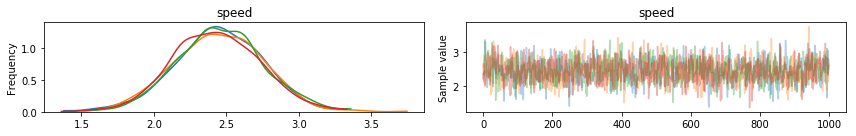

In [33]:
# Difference in hand hand dexterity
observed = (dx['HD'] == 'R', dx['HD'] == 'L')

for i in observed:
    with pm.Model() as model:
        speed = pm.Normal('speed',mu = dx.loc[i].Speed.mean(), sd = dx.loc[i].std())
        trace = pm.sample(1000)
        pm.traceplot(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [speed]
Sampling 4 chains: 100%|██████████| 64000/64000 [00:09<00:00, 6474.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [speed]
Sampling 4 chains: 100%|██████████| 64000/64000 [00:10<00:00, 6116.34draws/s]


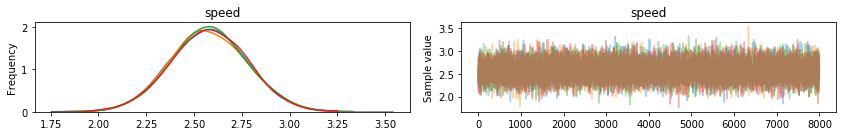

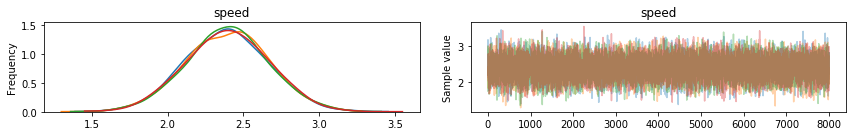

In [34]:
# Difference in hand used
observed = (dx['Used']=="R", dx['Used']=='L')

for i in observed:
    with pm.Model() as model:
        speed = pm.Normal('speed',mu = dx.loc[i].Speed.mean(), sd = dx.loc[i].std())
        trace = pm.sample(8000, tune =8000)
        pm.traceplot(trace)

## Social Desireability

As an example, suppose you ask 100 people to flip a coin and:

If they get heads, they report YES.

If they get tails, they honestly answer the question "Do you believe in God?"

Suppose that you get 80 Yes and 20 No after asking 100 students

In [21]:
# No data
N = 100
with pm.Model() as model:
    p = pm.Uniform("athesists", 0, 1)
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))
    coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [22]:
with model:
    val = coin_flips*true_answers 
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [23]:
observed = 20
with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=observed)

In [24]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [athesists]
>BinaryGibbsMetropolis: [truths, first_flips]
Sampling 4 chains: 100%|██████████| 162000/162000 [06:48<00:00, 396.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


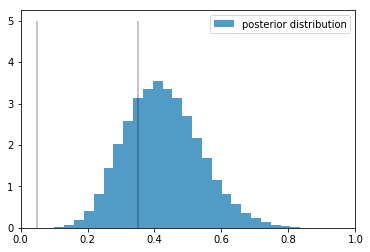

In [27]:
p_trace = burned_trace["athesists"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

Now another way of gathering the same information:

## Social Desireability 2

As an example, suppose you ask 100 people to flip a coin and:

If they get heads, they honestly answer the question "Do you believe in God?"

If they get tails, they flip a second coin and report YES for heads, tails for NO.

Assume that you cannot observe whether they flip one coin or two. And suppose you get 55 Yeses and 45 NOs.



In [10]:
N = 100
with pm.Model() as model:
    p = pm.Uniform("athesists", 0, 1)
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [6]:
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [7]:
observed = 45
with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=observed)

In [8]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [athesists]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 4 chains: 100%|██████████| 162000/162000 [11:00<00:00, 245.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


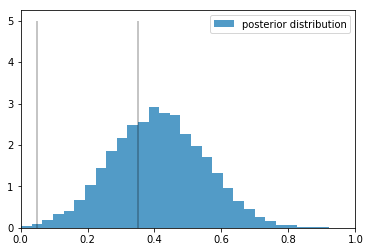

In [9]:
p_trace = burned_trace["athesists"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();